# Compartmental models of infectious diseases
Debasrija Mondal

### There are many ways to model the spread of an epidemic.
When we go down to specifics (maybe the spread of a certain disease in a district), models require careful fine-tuning to evaluate parameters. When we use more abstraction, maybe just think about a set of diseases that spread similarly, the models are more forgiving - it becomes easier to just look at an overall trend and understand its progress without worrying about numbers. <br>
Moreover, there are elements of randomness to the spread of diseases.

#### Our models here deal with infectious diseases.
Similarly other systems, like the spreaing of fake news follow dynamics surprisingly similar to the spread of infectious diseases.

## Talking about $R_{0}$
$R_{0}$ or the basic reproductive number is a measure of whether, and how fast, a disease can spread through a susceptible population. This term appeared a lot in media communications about COVID-19.<br>It depends on 3 factors - the probability of transmission at contact (i.e. how likely you are to get affected if you encounter an infected person), duration of infection and the rate of contact between an infected individual with the susceptible population. <br>
$R_{0}$ < 1 : epidemic dies out<br>
$R_{0}$ = 1 : epidemic perpetuated<br>
$R_{0}$ > 1 : epidemic spreads further (higher the value, quicker it spreads) <br><br>
Immediately, we note that one of the indicators of an epidemic being brought under control is a lowering of $R_{0}$ to less than 1. In this case, it means that an infected person can infect less than 1 person on average. Thus, eventually the epidemic dies out. However, $R_{0}$ is only an average over a considered population, so while a decreasing trend in its value is a good sign, one cannot say with certainty that the countering measures are working and restrictions should be relaxed.<br>For all we know, there just might be a hotspot in the country with low number of cases elsewhere. (That would yield a low $R_{0}$ on averaging over the country.) The moment the infected ones from the hotspot start to migrate, the entire country's population is at risk again.<br><br>For diseases where infection confers lifelong immunity, exposure with the infected individuals will not affect the ones who have already recovered. However, for diseases like COVID-19, where reinfection is quite likely, one cannot be declared safe after one bout of infection. 


## Compartmental models
They progress by dividing the entire population into compartments, with fractions of the population in each compartment cycling among themselves as patients go from, say, infected to recovered, or susceptible to infected. The beauty of such models are in their simplicity, and the endless customisation based on the disease parameters. (eg. whether or not the infection is fatal, whether there is latency period between being infected and being infectious, and so on) <br>Numerous such compartmental models can be formed but I will begin with the SIR model.

### SIR Model - from first principles
Individuals are divided into 3 compartments, where they remain in any one of three states - <br>
S - Susceptible (can catch the disease)<br>
I - Infectious (have caught the disease, and can transmit it to others)<br>
R - Recovered (have recovered from the disease), and are thus removed from the susceptible population<br>
An individual goes from susceptible, to infected, to recovered, and might or might not go to susceptible again based on whether or not the infection confers immunity. <br>Normally, we consider the Recovered ones as Removed, or not susceptible again.<br>One major assumption is that the population remains constant, S+I+R=N remains same throughout the period of observation.<br>The process of becoming infected, or moving between compartments S (susceptible) and I (infectious) in the SIR (Susceptible-Infectious-Recovered) model, is based on the assumption that infections are transmitted through direct contact between susceptible individuals and those who are already infected. If we further assume that everyone in the population has an equal likelihood of encountering one another, then there will be a total of S × I = SI interactions between susceptible and infectious individuals during each time period. 

Not all of the interactions result in a susceptible person becoming infectious. Only a fraction of SI are infectious contacts. thus, the change in S depends on both S and I, that is, how likely an infectious contact can be. We can take a parameter to define this change, and can call this parameter $p_{inf}$, the probability that an infectious individual infects a susceptible individual at first contact, or the fraction of contacts resulting in an infection. $\Delta$S denotes the change in S at every timestep (based on the decrease in the number of susceptible individuals due to infectious contacts): <br>
$$\Delta S = -p_{inf} * S * I $$We take $p_{rec}$ as the fraction of infected individuals recovering. The change in R depends on I only, because there are no more interactions involved. Then, $$\Delta R = p_{rec} * I $$.Coming to I, it should increase because people are moving from S to I, and also decrease when people move from I to R. After that, this equation becomes quite self-explanatory - $$\Delta I = p_{inf} * S * I - p_{rec} * I $$<br>Now, to take a look at how to model this computationally, beginning with importing the required packages (without using odeint) - <br>

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)

/tmp/ipykernel_202143/1656012669.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


In [2]:
def SIR_changes(p_inf, p_rec): #the quantities mean the same as the previous equations, hence not defining each quantity separately
    # turn the equations into update functions
    def deltaS(S, I, R):
        return -p_inf * S * I
    def deltaI(S, I, R):
        return p_inf * S * I - p_rec * I
    def deltaR(S, I, R):
        return p_rec * I
    
    # return the three functions
    return (deltaS, deltaI, deltaR)

If we start with some initial sub-population in each compartment, we can compute the change and add it to the previous population to get the population at the next timestep. We can do this repeatedly to trace out the behaviour of the epidemic in time. The result will be a time series for each sub-population tracking its size over time. (Euler's method)<br>Now, to drive the simulations - 

In [3]:
def SIR_compute(T, N, pInfected, p_inf, p_rec):
    #T - time elapsed in days
    #N - total population
    #pInfected - proportion of population that begins as infected. 
    #p_inf and p_rec mean the same as SIR_changes
    # create the change functions for these parameters
    (deltaS, deltaI, deltaR) = SIR_changes(p_inf, p_rec)
    
    # starting with the initial sub-populations
    s0 = [ N * (1.0 - pInfected) ] #s0 - initial susceptible number
    i0 = [ N * pInfected ] #i0 - initial infected number
    r0 = [ 0 ] #r0 - initial recovered number

    # update the value at each step. ds, di and dr are the changes in S, I and R per time step, based on the sub-populations of the previous step. 
    for t in range(1, T):
        ds = deltaS(s0[-1], i0[-1], r0[-1]) 
        di = deltaI(s0[-1], i0[-1], r0[-1])
        dr = deltaR(s0[-1], i0[-1], r0[-1])
        
        # the value at the next timestep are those at the previous timestep plus the value of the change in that value
        s0.append(s0[-1] + ds)
        i0.append(i0[-1] + di)
        r0.append(r0[-1] + dr)
        
    # return the time series
    return (list(range(0, T)), s0, i0, r0)

In [4]:
N = 1000 #population
T = 5000 #number of time steps
pInfected = 0.01 #1% of population begins as infected
p_rec = 0.001 #0.1% of population recovers at every time step

In [5]:
epidemics = {} #set of simulations with a set of actual p_inf values
for p_inf in [ 0.0000010, 0.0000020, 0.0000035, 0.0000040, 0.0000050, 0.0000080 ]:
    # run the epidemic equations
    epidemics[p_inf] = SIR_compute(T, N, pInfected, p_inf, p_rec)

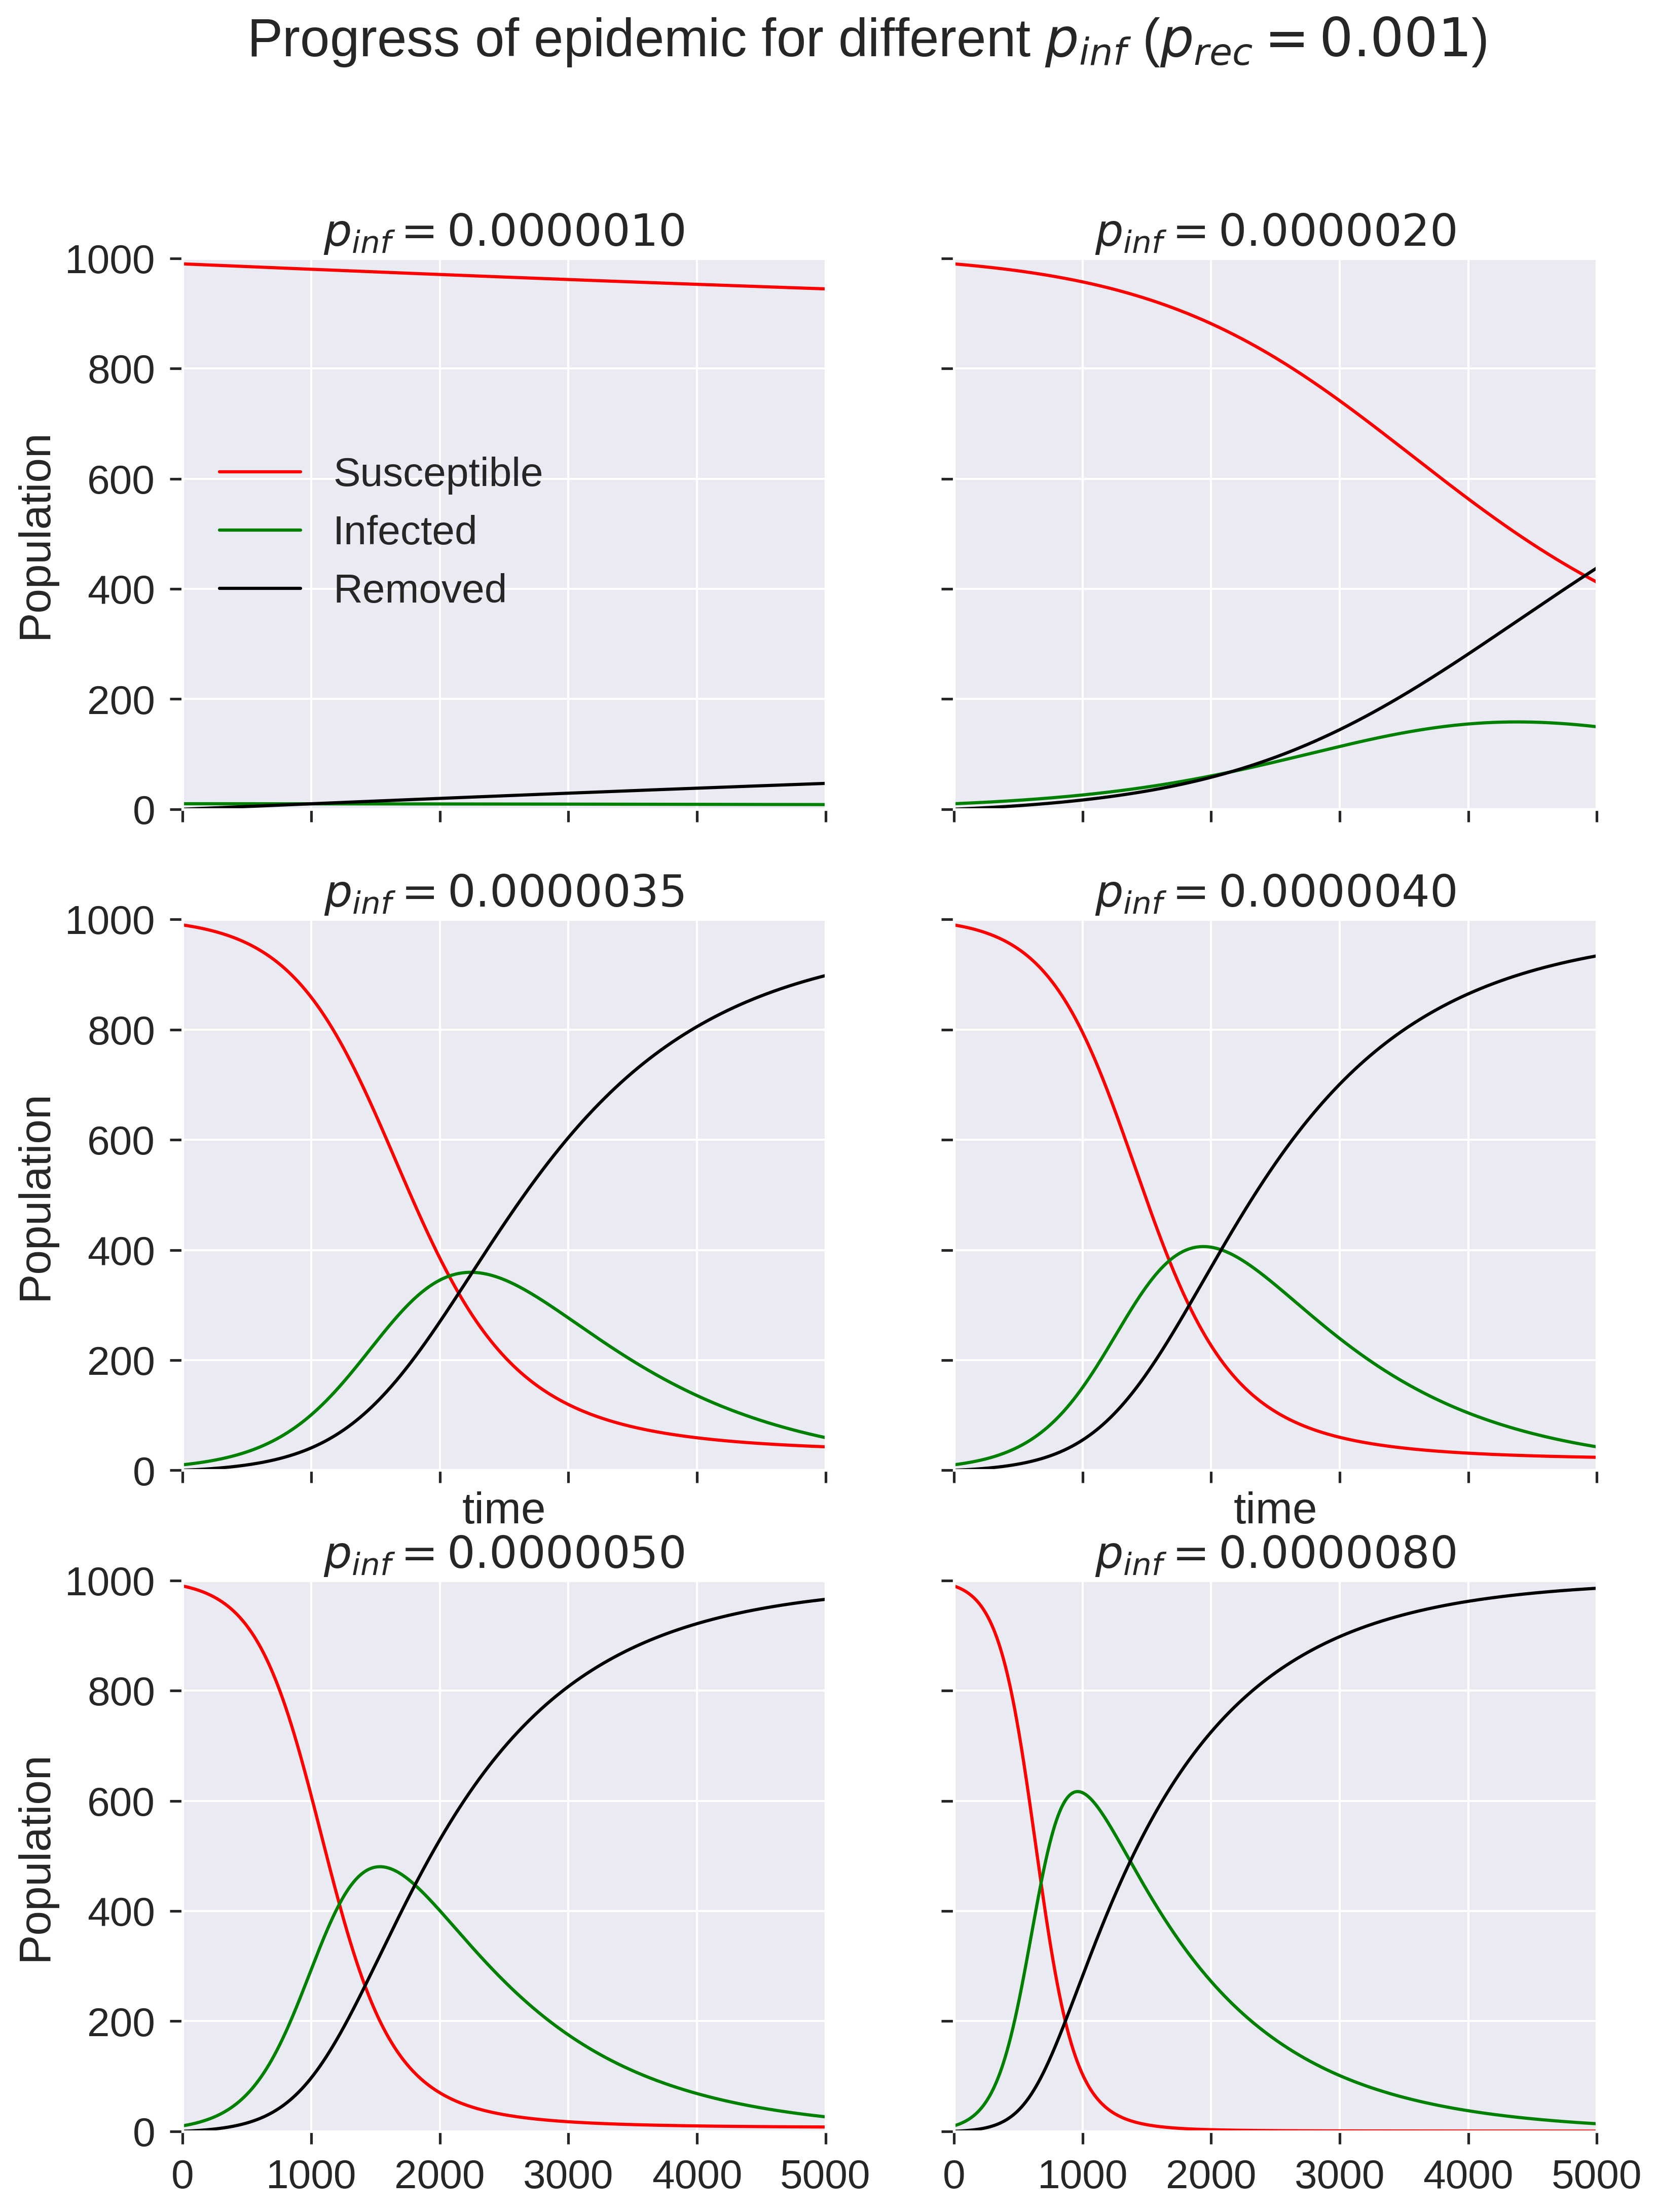

In [9]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 16))

# draw the sub-plots for selected values of pInfect
for (p_inf, ax) in [ (0.0000010, axs[0][0]), #same set of values as in epidemics[], each plot positioned
                       (0.0000020, axs[0][1]),
                       (0.0000035, axs[1][0]),
                       (0.0000040, axs[1][1]),
                       (0.0000050, axs[2][0]),
                       (0.0000080, axs[2][1]) ]:
    (ts, s0, i0, r0) = epidemics[p_inf]
    
    # draw the graph in the sub-plot
    ax.plot(ts, s0, 'r-', label='Susceptible')
    ax.plot(ts, i0, 'g-', label='Infected')
    ax.plot(ts, r0, 'k-', label='Removed')
    ax.set_title('$p_{\\mathit{inf}} = ' + '{b:.7f}$'.format(b=p_inf))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N])
    
# fine-tune the figure
plt.suptitle('Progress of epidemic for different $p_{\\mathit{inf}}$ ($p_{rec} = ' + '{a}$)'.format(a=p_rec))
for i in [0, 1, 2]:
    axs[i][0].set_ylabel('Population')
for i in[0, 1]:
    axs[1][i].set_xlabel('time')
axs[0][0].legend(loc='center left')
plt.show()

At the start of the epidemic (when t=0) there is a very small number of infected individuals and a very large number of susceptibles. The number of infecteds grows slowly as time passes - the graph moves from left to right. <br>But the disease is not very infectious in the first case: only 0.0001% of contacts leads to infection, just one in a million. At the start of the epidemic there are 990 susceptible people and 10 infected (1% of the total population), which means there can be at most 9900 susceptible-infected contacts. In the first timestep, then, the equations suggest that approximately 0.01 people become infected. Of course, this number is absurd. The number of infected persons has to grow to at least 1. And once infections start people also start to recover, and the epidemic never gets going.

Even for very low, but slightly larger values of p_inf – 0.000002 to 0.000008 (2 to 8 infectious contacts per million) – we get considerable epidemics. At the peak of infections around 20–60% of the population is infected, compared to essentially no one for p_inf = 0.000001. <br>Explains why, in a populous country like India, COVID-19 spread very easily. Just a shift of 7 infectious contacts per million is enough to get 60% of the population infected at its peak. <br>We have to be careful with our conclusions, though. The rate of infection is still just a notional concept, with no such concrete value. Moreover, it is impossible that time will not factor in this, (here we have just taken a random time period) and it is also impossible that the infection rate will not change with time, leaving a much more complex model in our hands. <br>However, this model is not entirely useless if we consider it to be a tool to understand the nature of an epidemic. Firstly, we see that **the epidemic grows exponentially** once it starts. We also observe that **it dies away exponentially** after its peak. The inherent **dynamicity** in the changing population of the infected people is also something worth noting.

#### Coding solutions - Package *odeint*
Our previous simulation worked more with 'difference' than 'differential' equations. Considering that our system can be defined by a continuous model (which it can, because there is always a flow of people between compartments), it makes more sense to use **differential equations**. To solve differential equations with numerical methods, Python provides the odeint package.

Here, we take a look at the differential equations. S, I and R have the same meanings as the difference equations, as does the total population N. A person is assumed to be infectious as soon as they are infected. First, the cycling between compartments:

$$\text{Susceptible}
\xrightarrow{\frac{\beta S I}{N}} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$
The quantities $\beta$ and $\gamma$ are defined as follows: 

* $\frac{\beta S I}{N}$ is the rate at which susceptible population encounters the infected population resulting in trasmission of the disease. $S$ is the size of the susceptible population. $\beta$ has the unit 1/day. $\beta$ is a rate constant associated with the transmission of the infection. Its reciprocal value corresponds to exponential growth of new infections in an initially susceptible population where $S=N$.
* $\gamma I$ is the rate at which infected population recovers and becomes resistant to further infection. $\gamma$ is the rate of recovery from infection. Its reciprocal is the average time needed to recover from an infection.
* If $\frac{\beta S}{N}$>$\gamma$, the infection progresses. Otherwise, it dies out.
* The ratio $R_0 = \frac{\beta}{\gamma}$ is the "Basic Reproduction Number" that describes the transmissability or contagiousness of an infectious disease. We have already discussed $R_0$.
* The population has 'herd immunity' when the fraction of susceptibles $\frac{S}{N}$ is less than $\frac{1}{R_0}$.

The SIR model for the spread of an infectious disease in a uniform population is given by the following deterministic (output invariant, if the initial conditions and input data values remain unchanged) equations (as before, $S+I+R=N$ is constant):

\begin{align*}
\frac{dS}{dt} & = -\frac{\beta S I}{N} \\
\frac{dI}{dt} & = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align*} 

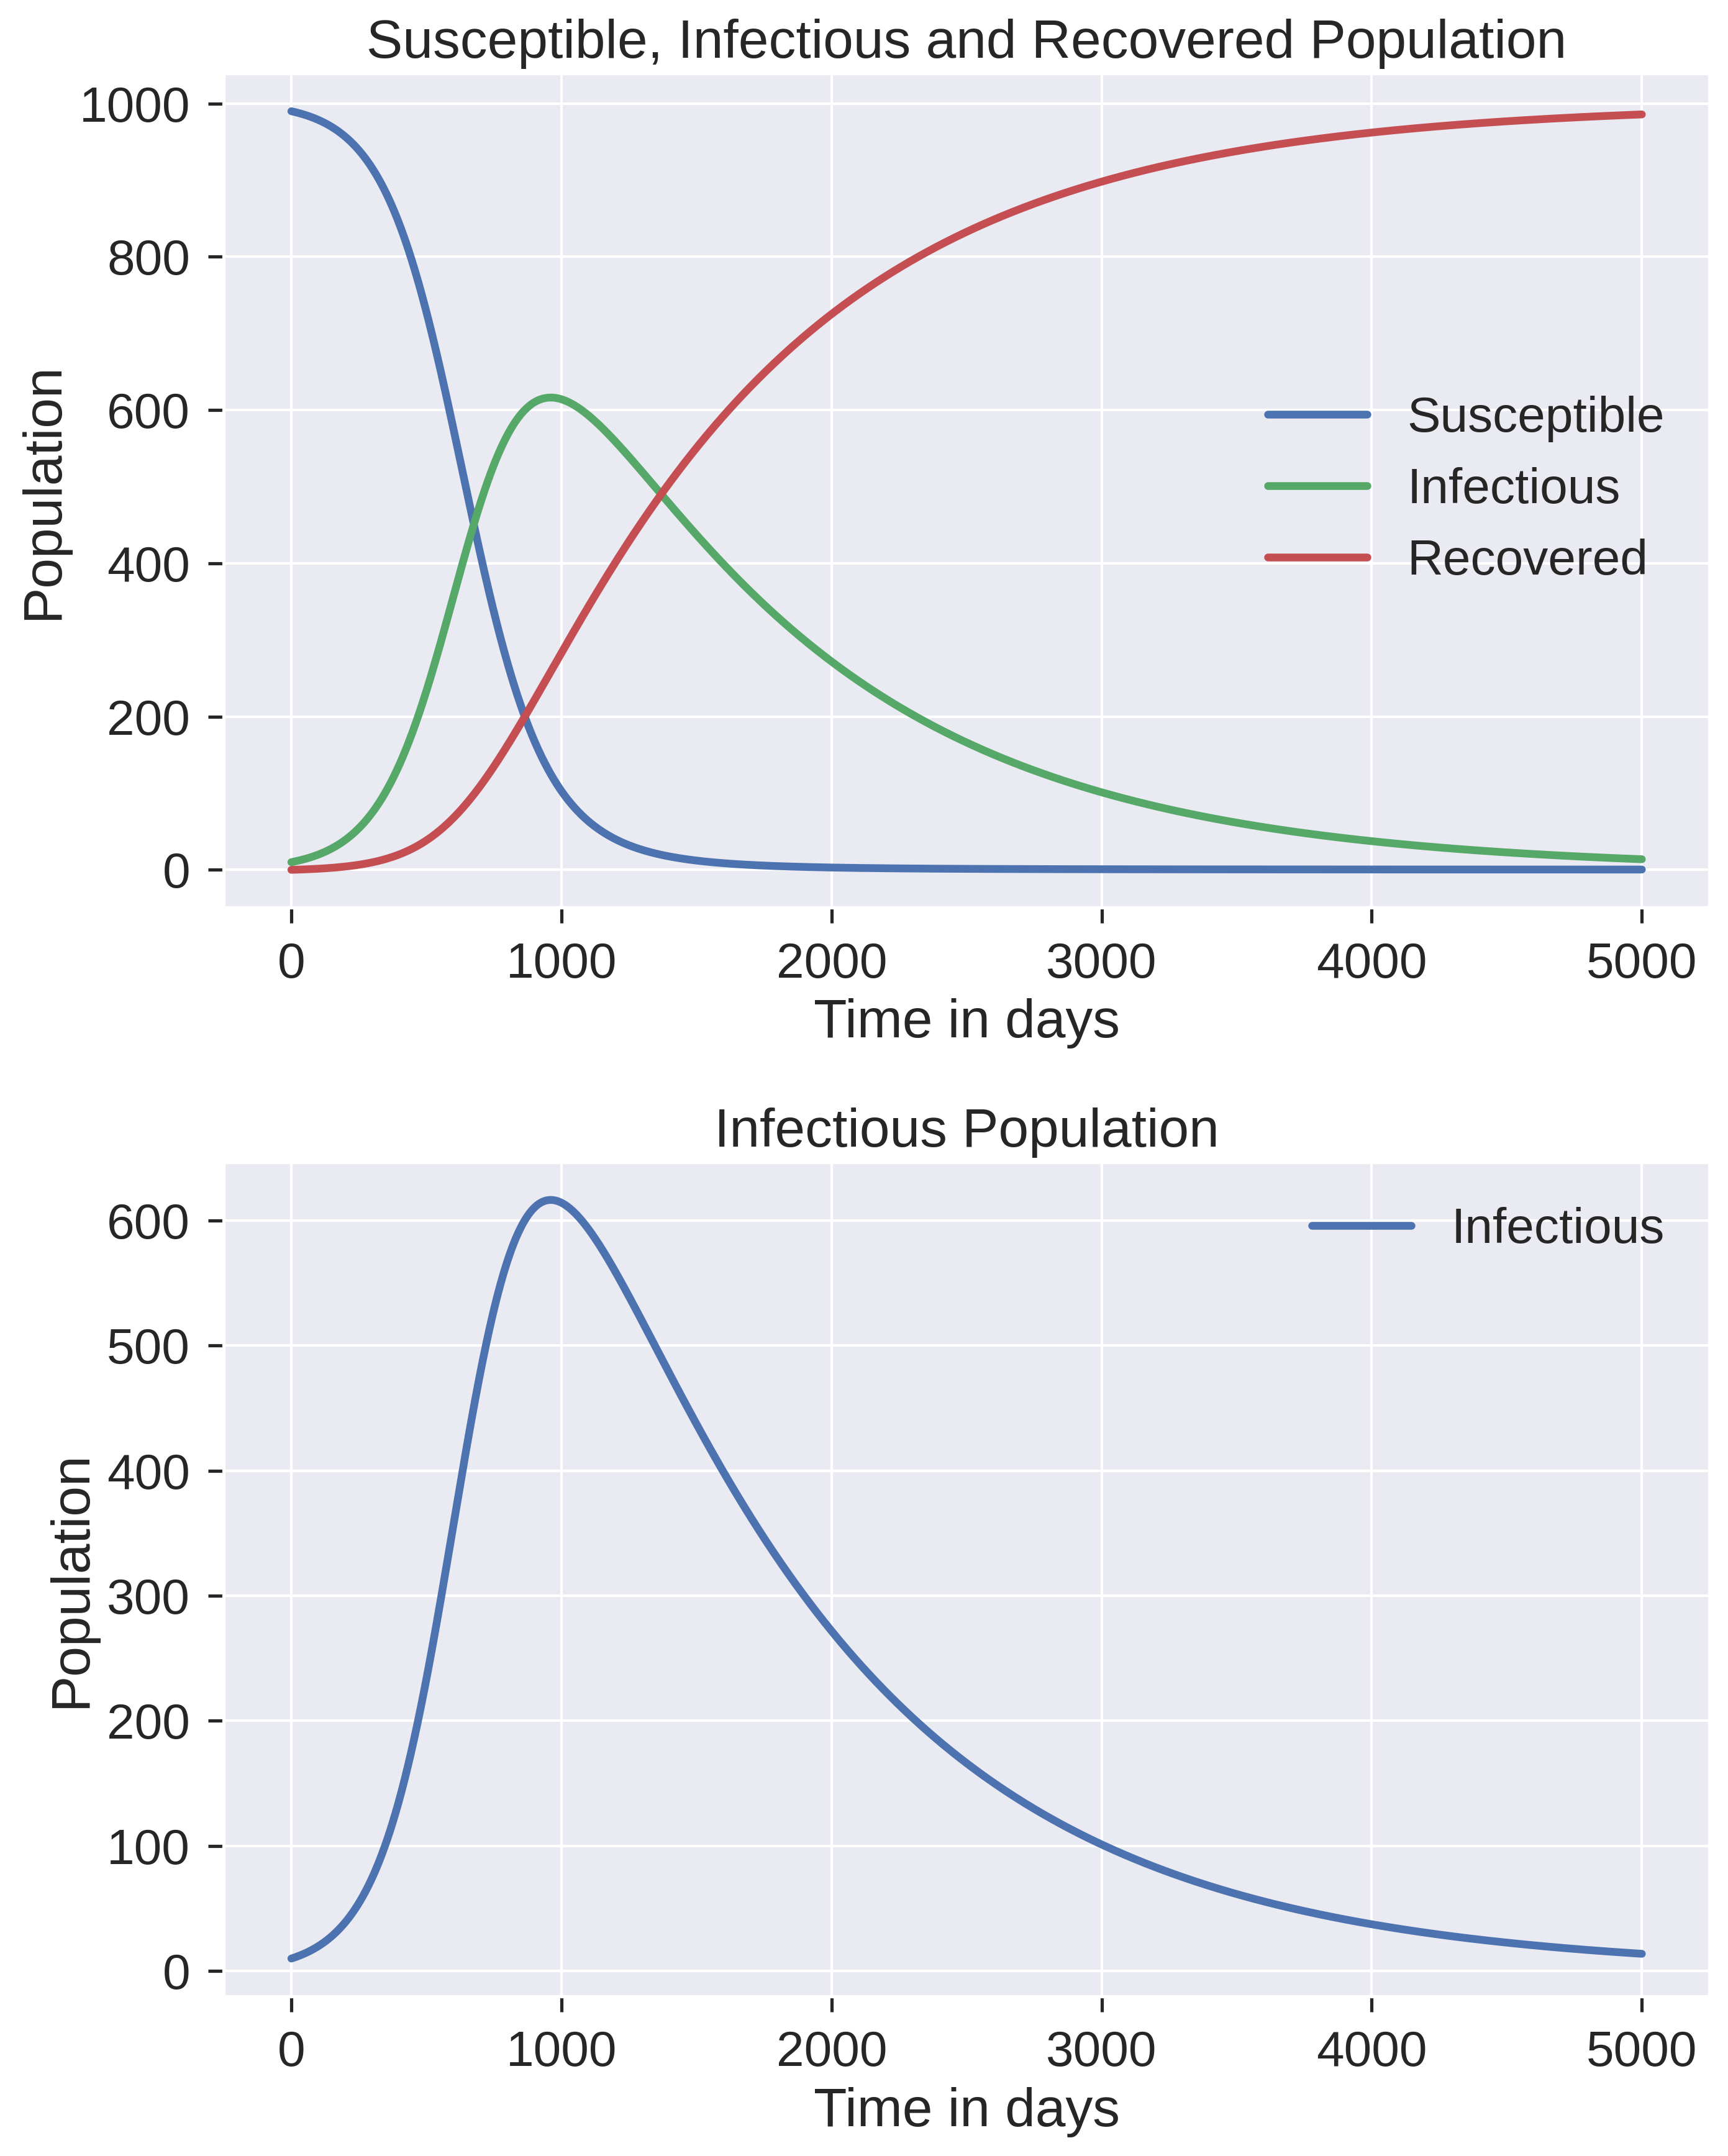

In [30]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
#R0 = 2.4 #Boldog et al
#t_infective = 8.4 #Boldog et al, infectious period

#parameter values
R0 = 8
t_infective = 1000
gamma = 1/t_infective
beta = R0 * gamma

# initial number of infected and recovered individuals
N=1000
I_initial = 0.01 * N
R_initial = 0
S_initial = N - I_initial - R_initial

# SIR model differential equations.
def SIR(x, t, N, beta, gamma):
    S, I, R = x
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt =  gamma * I
    return [dSdt, dIdt, dRdt]

t = np.linspace(0, 5000, 5000)
x_initial = S_initial, I_initial, R_initial
soln = odeint(SIR, x_initial, t, args=(N, beta, gamma)) #solving
S, I, R = soln.T

#plotting the data
def plotdata(t, S, I): 
    fig = plt.figure(figsize=(18,12))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223)]

    ax[0].plot(t, S, lw=3, label='Susceptible')
    ax[0].plot(t, I, lw=3, label='Infectious')
    ax[0].plot(t, R, lw=3, label='Recovered')
    ax[0].set_title('Susceptible, Infectious and Recovered Population')
    ax[0].set_xlabel('Time in days')
    ax[0].set_ylabel('Population')

    ax[1].plot(t, I, lw=3, label='Infectious')
    ax[1].set_title('Infectious Population')
    ax[1].set_xlabel('Time in days')
    ax[1].set_ylabel('Population')
    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()
plotdata(t, S, I)

As you can see, the results are the same as in the case of using difference equations. 